# Finding correlated mutations in cancer development

Documentation: 
- http://geco.deib.polimi.it/popstudy/api/ui/#/default/server.api.variant_distribution
- http://geco.deib.polimi.it/popstudy/api/ui/#/default/server.api.most_common_variant
- http://geco.deib.polimi.it/popstudy/api/ui/#/default/server.api.annotate

Requirements to run this demo: https://github.com/tomalf2/data_summarization_1KGP/blob/master/demo/README_requirements.txt

### Premise:
Usually tumor development is never associated to a single wrong nucleotide or short sequence, moreover our cells are capable to repair themselves when an error is found along the long sequence of 3 billions nucleotide pairs. However this sophisticated mechanism can fail if the mutations accumulate. That's why most diseases originate from particular conditions that usually involve many genes containing errors. Starting from this assumption, we can try to identify two mutations that are likely involved in tumor development.

We can make a function to help us sending a query to a desired endpoint and return the result

In [1]:
import requests
import json
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

def post_request(to: str, argument, print_status_code=True, print_warnings=True, timeout=None):
    resp = requests.post(to, json=argument, timeout=timeout)
    if print_status_code:
        print(' response status code: {}'.format(resp.status_code))
    res_body = resp.json()
    if resp.status_code != 200:
        print(res_body)
    if print_warnings:
        print('warnings ?: {}'.format(res_body.get('notice')))
    return res_body

Let's start this research by finding the somatic mutations that are more frequent in cancer patients. 

In [2]:
most_common_mutations_req = {
    'having_meta': {
        'assembly': 'grch38',
        'health_status': 'false'
    },
    'having_variants': {
        'in_cell_type': ['somatic']
    }
}
most_common_mutations_resp = post_request('http://geco.deib.polimi.it/popstudy/api/most_common_variants', most_common_mutations_req, print_status_code=False, print_warnings=False)

In [3]:
most_common_mutations_resp_df = pd.DataFrame.from_records(most_common_mutations_resp['rows'], columns=most_common_mutations_resp['columns'])
most_common_mutations_resp_df

,CHROM,START,REF,ALT,POPULATION_SIZE,POSITIVE_DONORS,OCCURRENCE_OF_VARIANT,FREQUENCY_OF_VARIANT
0,2,208248387,C,T,10187,383,383,0.018798
1,12,25245349,C,T,10187,182,185,0.009080
2,17,7675087,C,T,10187,148,168,0.008246
3,12,25245349,C,A,10187,148,149,0.007313
4,17,7673802,G,A,10187,99,128,0.006283
5,17,7674219,C,T,10187,117,126,0.006184
6,1,114713907,T,C,10187,108,109,0.005350
7,17,7673801,C,T,10187,89,98,0.004810
8,12,25245350,C,A,10187,87,90,0.004417
9,17,7674220,G,A,10187,82,88,0.004319


The result shows that the mutation __2:208248387-C-T, from now on "target mutation 1"__, is present in 1,8% of all patients. It may seem a very low frequency, but it's ok if we consider that we are not limiting our research to just a single specific disease. Let's find out in which population this portion is greater.

In [4]:
mut_1_req = {
    'having_meta': {
        'assembly': 'grch38',
        'health_status': 'false'
    },
    'having_variants': {
        'in_cell_type': ['somatic']
    },
    "target_variant": {"chrom":2, "start": 208248387, "ref":"C", "alt":"T"},
    "distribute_by": ["ethnicity", "gender"]
}
mut_1_req_resp = post_request('http://geco.deib.polimi.it/popstudy/api/variant_distribution', mut_1_req, print_status_code=False, print_warnings=False)

In [17]:
mut_1_req_resp_df = pd.DataFrame.from_records(mut_1_req_resp['rows'], columns=mut_1_req_resp['columns'])
mut_1_req_resp_df.fillna(value='', inplace=True)    # replaces Nones (== any value) with ''

df0 = mut_1_req_resp_df.pivot_table(mut_1_req_resp_df, ['ETHNICITY', 'GENDER'])
df0

FREQUENCY  \
ETHNICITY                                 GENDER                    
                                                         0.018798   
                                          female         0.016382   
                                          male           0.021579   
                                          not reported   0.006329   
american indian or alaska native                         0.000000   
                                          female         0.000000   
                                          male           0.000000   
asian                                                    0.006079   
                                          female         0.006873   
                                          male           0.005450   
black or african american                                0.008188   
                                          female         0.006130   
                                          male           0.011594   
native hawaiian or other pacific islander                0.000000   
                                          female         0.000000   
                                          male           0.000000   
not reported                                             0.004797   
                                          female         0.003348   
                                          male           0.006083   
                                          not reported   0.006329   
white                                                    0.022980   
                                          female         0.020232   
                                          male           0.025818   

                                                        OCCURRENCE_OF_TARGET_VARIANT  \
ETHNICITY                                 GENDER                                       
                                                                                 383   
                                          female                                 171   
                                          male                                   211   
                                          not reported                             1   
american indian or alaska native                                                   0   
                                          female                                   0   
                                          male                                     0   
asian                                                                              8   
                                          female                                   4   
                                          male                                     4   
black or african american                                                         15   
                                          female                                   7   
                                          male                                     8   
native hawaiian or other pacific islander                                          0   
                                          female                                   0   
                                          male                                     0   
not reported                                                                       9   
                                          female                                   3   
                                          male                                     5   
                                          not reported                             1   
white                                                                            351   
                                          female                                 157   
                                          male                                   194   

                                                        POPULATION_SIZE  \
ETHNICITY                                 GENDER      

For ease of inspection, we can plot the frequency of the TM1 by ethnicity and gender.

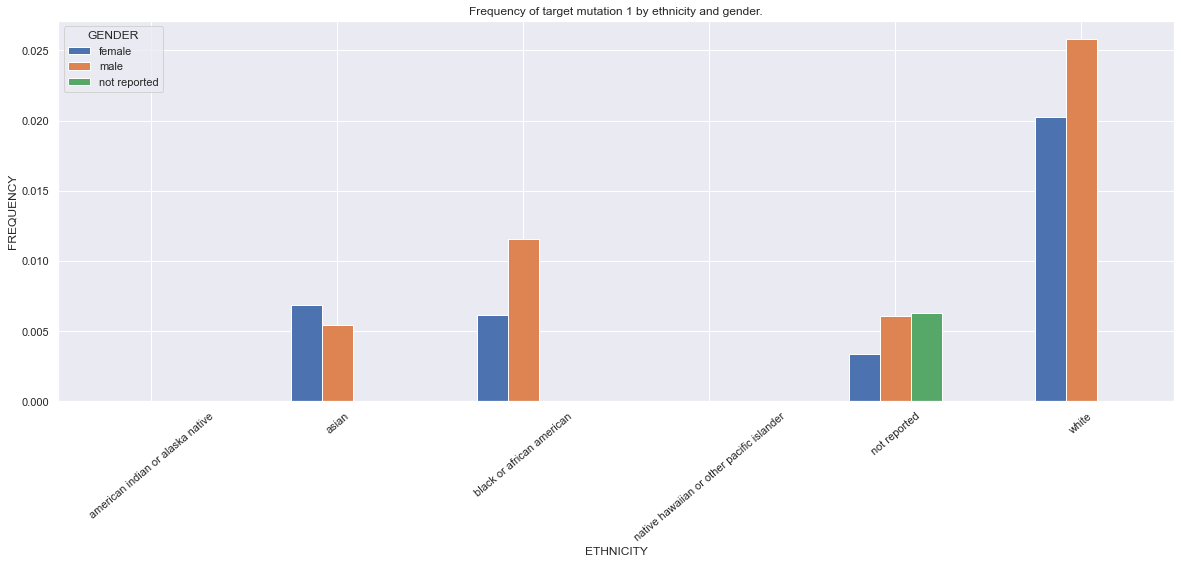

In [6]:
df1 = mut_1_req_resp_df.drop(mut_1_req_resp_df.query('GENDER == "" | ETHNICITY == ""').index) # drop aggregated values
df1.drop(['OCCURRENCE_OF_TARGET_VARIANT', 'POPULATION_SIZE', 'POSITIVE_DONORS'], inplace=True, axis=1) # drop other columns
plot = pd.pivot_table(df1, index='ETHNICITY', columns='GENDER', values='FREQUENCY').plot(
    kind='bar',
    figsize=(20, 7),
    legend=True
)
for item in plot.get_xticklabels():
     item.set_rotation(40)
plt.title('Frequency of target mutation 1 by ethnicity and gender.')
plt.ylabel('FREQUENCY')
plt.show()

The above plot tells the TM1 is peculiar to the white ethnicity, mostly males, and that it's frequency is more than double that of any other ethnic group. Also, the frequency of the target mutation raises to 2.2% in this ethnic group with respect to the previous results (1,8%) that involved all the populations.

## Finding the correlated mutation (or target mutation 2)

To find the TM2, we can rely on the possibility to restrict the population of interest through metadata and region constraints, by imposing the presence of the TM1 in the ethnic group white.

In [7]:
target_mut_2_req = {
    'having_meta': {
        'assembly': 'grch38',
        'health_status': 'false',
        "ethnicity": ["white"]
    },
    'having_variants': {
        'in_cell_type': ['somatic'],
        "with": [{                  # impose presence of TM1 in patients
            "chrom":2, "start": 208248387, "ref":"C", "alt":"T"
        }]
    }
}
target_mut_2_resp = post_request('http://geco.deib.polimi.it/popstudy/api/most_common_variants', target_mut_2_req, print_status_code=False, print_warnings=False)

In [8]:
target_mut_2_resp_df = pd.DataFrame.from_records(target_mut_2_resp['rows'], columns=target_mut_2_resp['columns'])
target_mut_2_resp_df

,CHROM,START,REF,ALT,POPULATION_SIZE,POSITIVE_DONORS,OCCURRENCE_OF_VARIANT,FREQUENCY_OF_VARIANT
0,2,208248387,C,T,351,351,351,0.500000
1,17,7673802,G,A,351,35,54,0.076923
2,17,7674871,T,C,351,9,15,0.021368
3,17,7673801,C,T,351,9,13,0.018519
4,17,7675087,C,T,351,6,9,0.012821
5,23,77654138,G,A,351,6,6,0.011811
6,17,7674219,C,T,351,7,8,0.011396
7,17,7675075,T,C,351,5,8,0.011396
8,24,5737916,C,T,351,1,2,0.010309
9,19,42287604,C,T,351,7,7,0.009972


The mutation more frequently found in patients with TM1 is __17:7673802-G-A (from now on TM2)__, which occurs in 7.6% of patients, mostly as a heterozygous mutation. 

However, the correlation TM1->TM2 is not high, __but what about the opposite direction, i.e. TM2->TM1 ? We can check it by querying the variant distribution of TM1 in patients where TM2 is present.__

In [9]:
freq_distr_of_1_when_2_req = {
    'having_meta': {
        'assembly': 'grch38',
        'health_status': 'false',
        "ethnicity": ["white"]
    },
    'having_variants': {
        'in_cell_type': ['somatic'],
        "with": [{"chrom":17, "start": 7673802, "ref":"G", "alt":"A"}]
    },
    "target_variant": {"chrom":2, "start": 208248387, "ref":"C", "alt":"T"},
    "distribute_by": ["gender"]
}
freq_distr_of_1_when_2_res = post_request('http://geco.deib.polimi.it/popstudy/api/variant_distribution', freq_distr_of_1_when_2_req, print_status_code=False, print_warnings=False)

In [10]:
freq_distr_of_1_when_2_res_df = pd.DataFrame.from_records(freq_distr_of_1_when_2_res['rows'], columns=freq_distr_of_1_when_2_res['columns'])
freq_distr_of_1_when_2_res_df.fillna(value='', inplace=True)    # replaces Nones (== any value) with ''

df20 = freq_distr_of_1_when_2_res_df.pivot_table(freq_distr_of_1_when_2_res_df, ['GENDER'])
df20

,FREQUENCY,OCCURRENCE_OF_TARGET_VARIANT,POPULATION_SIZE,POSITIVE_DONORS
GENDER,,,,
,0.201149,35,87,35
female,0.192308,20,52,20
male,0.214286,15,35,15


### Interestingly, the observation of the TM1 frequency when TM2 is present, is much higher than the inverse. We could say that 1/5 of the white males patients carrying the TM2, also have TM1. 

Even if this isn't enough to hypothesize a cause and effect link type, it suggests that __the two are linked in a unidirectional way__. This may reflect the nature of the genes where the two mutations fall into.

In [11]:
annotate_req_template = {
    "assembly": "grch38",
    "chrom": "???",
    "start": "??",
    "ref": "??",
    "alt": "??"
}

annotate_req_template['chrom'] = 2
annotate_req_template['start'] = 208248387
annotate_req_template['ref'] = "C"
annotate_req_template['alt'] = "T"
gene_TM1 = post_request('http://geco.deib.polimi.it/popstudy/api/annotate', annotate_req_template, print_status_code=False, print_warnings=False)

annotate_req_template['chrom'] = 17
annotate_req_template['start'] = 7673802
annotate_req_template['ref'] = "G"
annotate_req_template['alt'] = "A"
gene_TM2 = post_request('http://geco.deib.polimi.it/popstudy/api/annotate', annotate_req_template, print_status_code=False, print_warnings=False)

In [12]:
genes = pd.DataFrame([gene_TM1['rows'][0], gene_TM2['rows'][0]], columns = ['CHROM', 'START', 'STOP', 'STRAND', 'GENE_SYMBOL', 'GENE_TYPE'], index=['TM1', 'TM2'])
genes

,CHROM,START,STOP,STRAND,GENE_SYMBOL,GENE_TYPE
TM1,2,208236226,208266074,-1,IDH1,protein_coding
TM2,17,7661778,7687550,-1,TP53,protein_coding


### Staring without any information, we identified a likely gene interaction in cancer development, suggesting that the alteration of gene TP53 through the mutation 17:7673802-G-A is likely to alterate directly or indirectly the IDH1 gene in 1/5 of the population, resulting in the mutation 2:208248387-C-T being one of the most common ones in persons of white ethnicity, with males slightly more affected than females.

This statement is also confirmed by a study published in Neuro Oncology "IDH1 mutations are present in the majority of common adult gliomas but rare in primary glioblastomas" which states: "The data indicate that IDH1 mutation combined with either TP53 mutation or total 1p/19q loss is a frequent and early change in the majority of oligodendroglial tumors, diffuse astrocytomas, anaplastic astrocytomas, and secondary glioblastomas  \[...]".

Finally now that we have more information, we can test if this correlation is observed also in ethnies other than white and if it is equally present between genders.

In [13]:
# We can obtain the request parameter by modifying accordingly a copy of freq_distr_of_1_when_2_req
freq_distr_of_1_when_2_req_new = freq_distr_of_1_when_2_req.copy()
del freq_distr_of_1_when_2_req_new["having_meta"]["ethnicity"]
freq_distr_of_1_when_2_req_new["distribute_by"] = ["ethnicity", "gender"]

freq_distr_of_1_when_2_res_new = post_request('http://geco.deib.polimi.it/popstudy/api/variant_distribution', freq_distr_of_1_when_2_req_new, print_status_code=False, print_warnings=False)

In [14]:
freq_distr_of_1_when_2_res_new_df = pd.DataFrame.from_records(freq_distr_of_1_when_2_res_new['rows'], columns=freq_distr_of_1_when_2_res_new['columns'])
freq_distr_of_1_when_2_res_new_df.fillna(value='', inplace=True)    # replaces Nones (== any value) with ''

df30 = freq_distr_of_1_when_2_res_new_df.pivot_table(freq_distr_of_1_when_2_res_new_df, ['ETHNICITY', 'GENDER'])
df30

FREQUENCY  \
ETHNICITY                        GENDER                    
                                                0.176768   
                                 female         0.169492   
                                 male           0.192308   
                                 not reported   0.000000   
american indian or alaska native                0.000000   
                                 female         0.000000   
asian                                           0.000000   
                                 female         0.000000   
                                 male           0.000000   
black or african american                       0.000000   
                                 female         0.000000   
                                 male           0.000000   
not reported                                    0.000000   
                                 female         0.000000   
                                 male           0.000000   
                                 not reported   0.000000   
white                                           0.201149   
                                 female         0.192308   
                                 male           0.214286   

                                               OCCURRENCE_OF_TARGET_VARIANT  \
ETHNICITY                        GENDER                                       
                                                                         35   
                                 female                                  20   
                                 male                                    15   
                                 not reported                             0   
american indian or alaska native                                          0   
                                 female                                   0   
asian                                                                     0   
                                 female                                   0   
                                 male                                     0   
black or african american                                                 0   
                                 female                                   0   
                                 male                                     0   
not reported                                                              0   
                                 female                                   0   
                                 male                                     0   
                                 not reported                             0   
white                                                                    35   
                                 female                                  20   
                                 male                                    15   

                                               POPULATION_SIZE  \
ETHNICITY                        GENDER                          
                                                            99   
                                 female                     59   
                                 male                       39   
                                 not reported                1   
american indian or alaska native                             1   
                                 female                      1   
asian                                                        2   
                                 female                      1   
                                 male                        1   
black or african american                                    6   
                                 female                      4   
                                 male                        2   
not reported                                                 3   
                                 female                      1   
                                 male                        1   
    

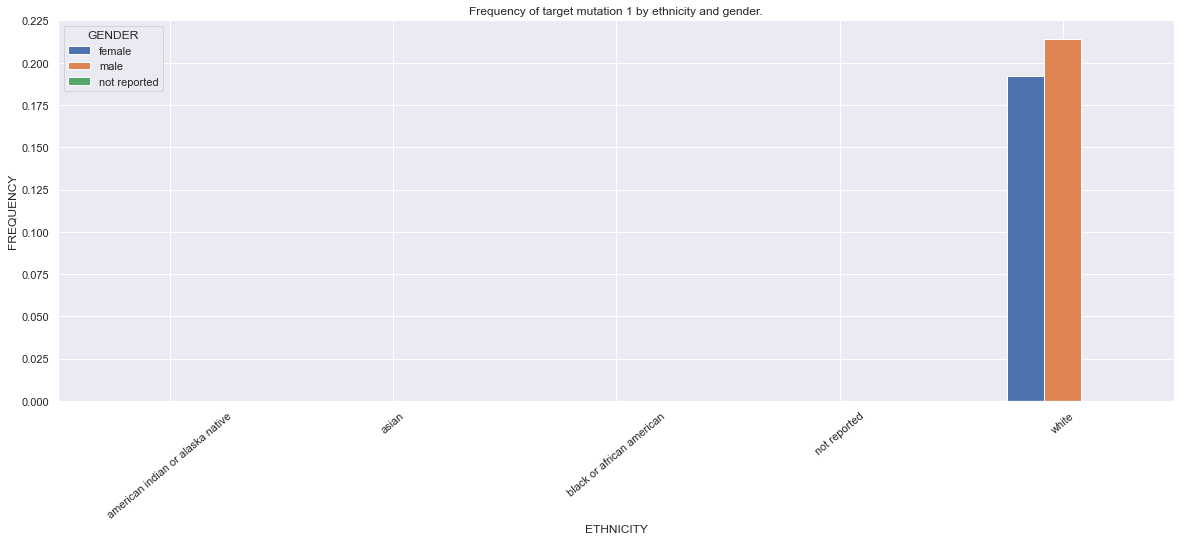

In [15]:
df31 = freq_distr_of_1_when_2_res_new_df.drop(freq_distr_of_1_when_2_res_new_df.query('GENDER == "" | ETHNICITY == ""').index) # drop aggregated values
df31.drop(['OCCURRENCE_OF_TARGET_VARIANT', 'POPULATION_SIZE', 'POSITIVE_DONORS'], inplace=True, axis=1) # drop other columns
plot = pd.pivot_table(df31, index='ETHNICITY', columns='GENDER', values='FREQUENCY').plot(
    kind='bar',
    figsize=(20, 7),
    legend=True
)
for item in plot.get_xticklabels():
     item.set_rotation(40)
plt.title('Frequency of target mutation 1 by ethnicity and gender.')
plt.ylabel('FREQUENCY')
plt.show()

This result indicates that this correlation is basically absent in all the other ethnies and gender combinations.

References:
- Ichimura, K., Pearson, D. M., Kocialkowski, S., Bäcklund, L. M., Chan, R., Jones, D. T., & Collins, V. P. (2009). IDH1 mutations are present in the majority of common adult gliomas but rare in primary glioblastomas. Neuro-oncology, 11(4), 341–347. https://doi.org/10.1215/15228517-2009-025